# Santander Customer Satisfaction

https://www.kaggle.com/c/santander-customer-satisfaction/overview

From frontline support teams to C-suites, customer satisfaction is a key measure of success. Unhappy customers don't stick around. What's more, unhappy customers rarely voice their dissatisfaction before leaving.

Santander Bank is asking Kagglers to help them identify dissatisfied customers early in their relationship. Doing so would allow Santander to take proactive steps to improve a customer's happiness before it's too late.

In this competition, you'll work with hundreds of anonymized features to predict if a customer is satisfied or dissatisfied with their banking experience.

### Setup

In [155]:
from pathlib import Path
import os

FILE_PATH = Path("Santander-customer-satisfaction")
is_correct_dir = Path(str(Path(os.getcwd())).rsplit("\\")[-1]) == FILE_PATH
if is_correct_dir:
    os.chdir("../")

import numpy as np
import pandas as pd
import seaborn as sns
sns.set(rc = {'figure.figsize':(10, 6)})
from sklearn.metrics import roc_auc_score

from mlutils.preprocess.missing import check_missingness
from mlutils.preprocess.pipeline import extract_x_y
from mlutils.visualise.features import plot_importances

In [156]:
# Load data
train = pd.read_csv(FILE_PATH / "Data/train.csv").drop("ID", axis=1)

**No missing data**

In [157]:
check_missingness(train)

,pct_missing


# Todo:
 - Look at distribution of feature variances and medians/means
 - Investigate whether low variance features affect the target. If they don't - just drop before main feature selection.
 - Try over/under sampling
 - Catboost, tune submit and done

### EDA


This data set is highly dimensional (370 features).

In [158]:
train.shape

(76020, 370)

**Target**

Positive class: 3.96%


C:\Users\joshu\.virtualenvs\kaggle-competitions-jWZu0GdS\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


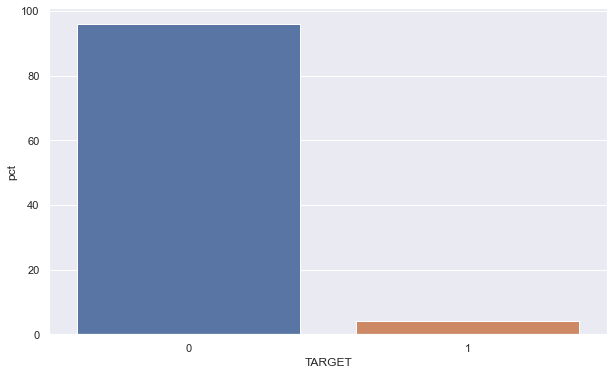

In [248]:
def plot_target_imbalance(df: pd.DataFrame) -> pd.DataFrame:
    df = np.round(df["TARGET"].value_counts() / df.shape[0] * 100, 2).reset_index()
    df.columns = ["TARGET", "pct"]
    sns.barplot(df["TARGET"], df["pct"])

plot_target_imbalance(train)
print(f'Positive class: {np.round(sum(train["TARGET"] == 1) / train.shape[0]*100, 2)}%')

### Preprocessing

In [249]:
X, y = extract_x_y(train, "TARGET")

### Feature reduction

Run k fold stratified cv, and average each features importance

In [163]:
%%capture 

from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

xgb = XGBClassifier()

kfold = StratifiedKFold(n_splits=5)

f_importances = []
for fold,( train_idx, test_idx) in enumerate(kfold.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_test, y_test = X.iloc[test_idx], y[test_idx]

    xgb.fit(X_train, y_train)

    f_importances.append(pd.DataFrame({
        "fold": fold,
        "feature": X_train.columns,
        "importance": xgb.feature_importances_
    }))

f_importances = pd.concat(f_importances)
f_importances["mean_importance"] = f_importances.groupby("feature")["importance"].transform(np.mean)
f_importances.sort_values("mean_importance", ascending=False, inplace=True)

array(['saldo_var30', 'var15', 'ind_var26_cte', 'ind_var41_0',
       'num_var42_0', 'num_op_var39_efect_ult3', 'num_var4',
       'imp_op_var39_efect_ult1', 'var3', 'saldo_medio_var5_hace2',
       'imp_op_var39_ult1', 'saldo_medio_var5_hace3',
       'imp_op_var41_efect_ult3', 'saldo_var13_corto',
       'saldo_medio_var5_ult1', 'num_var22_ult1', 'num_op_var39_ult3',
       'ind_var30', 'imp_op_var41_ult1', 'saldo_medio_var5_ult3',
       'num_var35', 'imp_op_var41_efect_ult1', 'ind_var5', 'var38',
       'num_var22_ult3', 'num_var26_0', 'ind_var8_0',
       'num_op_var39_hace2', 'num_op_var41_ult3',
       'num_meses_var39_vig_ult3', 'ind_var25_cte',
       'saldo_medio_var8_ult1', 'saldo_var37', 'num_meses_var5_ult3',
       'saldo_var8', 'num_var39_0', 'imp_op_var39_efect_ult3',
       'imp_var43_emit_ult1', 'imp_op_var41_comer_ult3',
       'imp_ent_var16_ult1'], dtype=object)

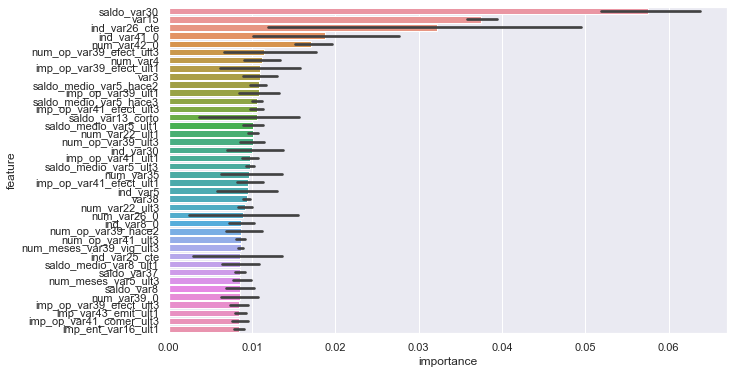

In [164]:
N_FEATURES = 40

def get_top_n_features(f_importances: pd.DataFrame, n_features: int, plot: bool=True) -> pd.DataFrame:
    top_n_features = (
        f_importances[["feature", "mean_importance"]]
        .drop_duplicates()
        .head(n_features)
        ["feature"]
        .values
    )

    if plot:
        sns.barplot(
            data=f_importances[f_importances["feature"].isin(top_n_features)], 
            x="importance",
            y="feature", 
            estimator=np.mean
        )
    return top_n_features

get_top_n_features(f_importances, N_FEATURES)

### Dealing with class imbalance

### Basline model

**Baseline feature selected model**

In [243]:
%%capture

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

features = get_top_n_features(f_importances, N_FEATURES, plot=False)

xgb = XGBClassifier(max_depth=6, n_estimators=50)
cv_results = cross_val_score(xgb, X[features], y, cv=5, scoring="roc_auc")

In [260]:
%%capture

N_CV = 5

kfold = StratifiedKFold(n_splits=N_CV)

train_accuracy, test_accuracy = [], []

for train_idx, test_idx in kfold.split(X, y):
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_test, y_test = X.iloc[test_idx], y[test_idx]

    xgb.fit(X_train, y_train)
    y_hat_train = xgb.predict_proba(X_train)[:, 1]
    y_hat_test = xgb.predict_proba(X_test)[:, 1]

    train_accuracy.append(roc_auc_score(y_train, y_hat_train))
    test_accuracy.append(roc_auc_score(y_test, y_hat_test))

Mean train score 0.9105491700995574
Mean test score 0.8305096470626724


<AxesSubplot:xlabel='fold', ylabel='accuracy'>

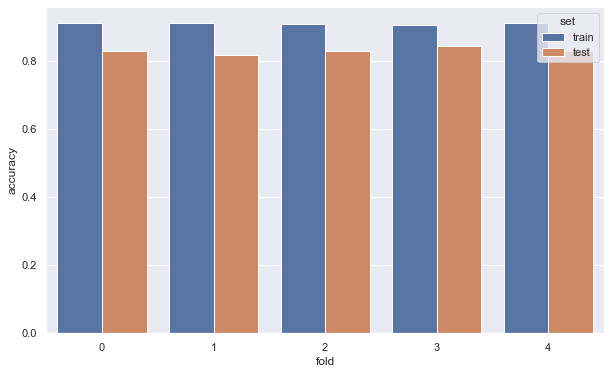

In [261]:
results_df = pd.DataFrame({
    "fold": list(range(N_CV)),
    "train": train_accuracy,
    "test": test_accuracy
})
results_df = pd.melt(results_df, id_vars="fold", var_name="set",value_name="accuracy")
print(f"Mean train score {np.mean(train_accuracy)}")
print(f"Mean test score {np.mean(test_accuracy)}")
sns.barplot(data=results_df, x="fold", y="accuracy", hue="set")

### Predict test set and submit

In [244]:
%%capture

xgb.fit(X[features], y)

In [246]:
# Load test set
test = pd.read_csv(FILE_PATH / "Data/test.csv")
test["TARGET"] = xgb.predict_proba(test[features])[:, 1]

C:\Users\joshu\.virtualenvs\kaggle-competitions-jWZu0GdS\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [247]:
test[["ID", "TARGET"]].to_csv(FILE_PATH / "Data/test_predictions.csv", index=False)